A first pass at digital frequency synthesis is relatively easy to pull off using some simple tricks in Python. It's not rocket science to string together a basic accumulator and a sine lookup table to make a sine wave output. However, we left off noting some spurious output in the synthesized sine wave. What can we do about that? 

Can't go anywhere until you fire up some data libraries:

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from dds import DirectDigitalSynthesis

%matplotlib inline

I saved myself some copypasta by bundling all of my old direct digital synthesis functions into a handy class that generates the numpy arrays given a set sampling frequency, accumulator depth, ROM size, and truncation width. If you'd like to see how I did this, you can check out the raw source at: https://github.com/Cushychicken/dds-engine/blob/main/tools/dds.py

...and now I wave the magic wand of functions...

In [2]:
dds      = DirectDigitalSynthesis(100000000, 32, 4096, 12)
freq     = 2822400
tuning   = dds.freq_to_tuning(freq)
phase    = dds.generate_phase_array(tuning, (2**20))
df_phase = dds.generate_dds_frame(dither_output=True)
df_fft   = dds.generate_dds_spectrum()

...and receive those sweet, sweet Fourier coefficients in return:

<ipython-input-3-0c77e9762e87>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,2)


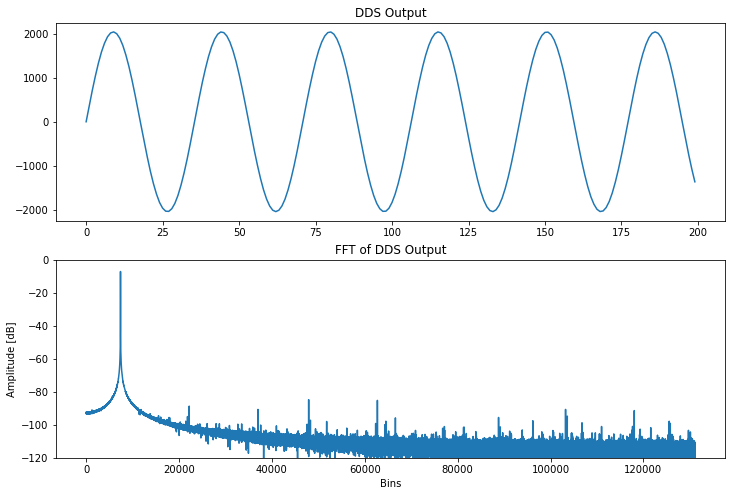

In [3]:
# Shortening the time domain plot so sine features are visible
plot_len = 200

fig = plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(df_phase[:plot_len])
plt.title("DDS Output")

plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

fft_index = int(len(df_fft)/2) # Half of the FFT output 
plt.plot(df_fft[:fft_index])
plt.title("FFT of DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')
#plt.xlim(29590,29600)
plt.show()

One of the options I bundled into this new `DirectDigitalSynthesis` class was the ability to dither the synthesizer's output. By default, the call to the method `generate_dds_frame()` will now add a dithering stream to the phase accumulator. 

In [ ]:
def generate_dds_frame(self, dither_output=True):
    """ Returns dds sine output from stored values in self.phase

    Keyword Arguments:
    dither_output   -- add phase dither to dds signal (default True)
    """
    # Programmatically generates mask to truncate all but most sig bits
    shift = self.acc_depth - self.bit_depth
    mask  = 2 ** self.acc_depth - 1
    mask  = mask - (2 ** (shift) - 1)

    dds_frame = np.zeros(len(self.phase))
    if dither_output:
        dither = np.random.randint(2, size=len(self.phase))
        dither = np.left_shift(dither, (shift-1))
        dds_frame = np.add(self.phase, dither)
    else:
        dds_frame = np.array(self.phase)

    dds_frame = np.bitwise_and(dds_frame, mask)
    self.phase_trunc = np.right_shift(dds_frame, shift)

    # Apply sin rom with lambda function (phase-to-amplitude)
    sin_lookup = lambda x: self.sin_rom[x]
    self.dds_out = np.array([sin_lookup(x) for x in self.phase_trunc])
    return(self.dds_out)

The dithering stream is a random sequence of 1's and 0's at a bit significance one less than the truncation bit depth. I.E. - if you're truncating your phase accumulator to 12 bits, then your dithered bits should be the 13th bit less than the MSB. That's the purpose of the excitement with `np.left_shift()` - it's moving the 1's and 0's created by `randint()` up to the LSB significance of the truncated phase register's LSB. 

Signal wise, this dithering bitstream is just noise. However, it serves a _very_ cool purpose in a DDS application. 

Observe the following DDS example, where dithering has been turned off in the output waveform:`

<ipython-input-53-1170c315ba5c>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,2)


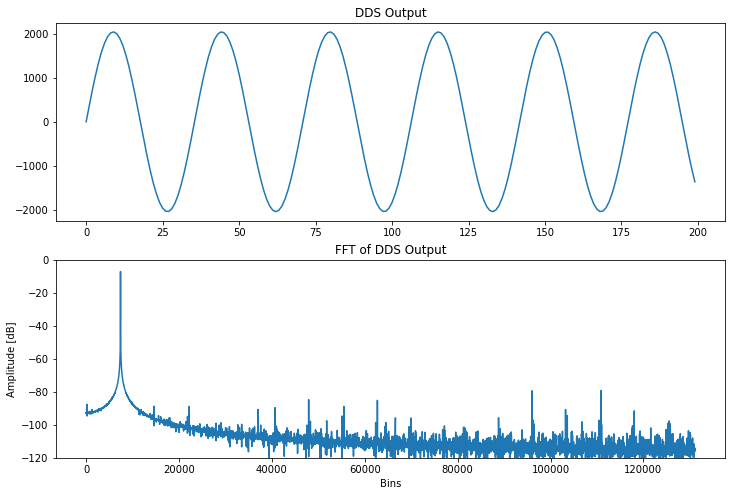

In [53]:
dds      = DirectDigitalSynthesis(100000000, 32, 4096, 12)
freq     = 2822400
tuning   = dds.freq_to_tuning(freq)
phase    = dds.generate_phase_array(tuning, (2**20))
df_phase = dds.generate_dds_frame(dither_output=False)
df_fft   = dds.generate_dds_spectrum()

# Shortening the time domain plot so sine features are visible
plot_len = 200

fig = plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(df_phase[:plot_len])
plt.title("DDS Output")

plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

fft_index = int(len(df_fft)/2) # Half of the FFT output 
plt.plot(df_fft[:fft_index])
plt.title("FFT of DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')
#plt.xlim(29590,29600)
plt.show()

Just by looking at the FFT, we can see a number of bins popping up through the -90dB mark. A quick list comprehension can filter out those bins by magnitude for our observation:

In [4]:
spur_mags = [ a for a in df_fft[15000:fft_index] if a > -90]
print(spur_mags)
print("Bin Count: ", len(spur_mags))
print("Max Spur : ", max(spur_mags))

[-88.64420189270179, -84.72147302509804, -85.14216103766753]
Bin Count:  3
Max Spur :  -84.72147302509804


There are nine FFT bins that pop up above this threshold. The max of these bins is just over -80dB in magnitude. 

Turn on dithering, however, and the story changes! The dithering bitstream cuts down the number of spurious frequencies by two thirds. It also improves SFDR by about 6dB!

In [55]:
phase_dither = dds.generate_dds_frame(dither_output=True)
df_dither_fft   = dds.generate_dds_spectrum()
spur_mags = [ a for a in df_dither_fft[15000:fft_index] if a > -90]
print(spur_mags)
print("Bin Count: ", len(spur_mags))
print("Max Spur : ", max(spur_mags))

[-88.8091084165903, -84.72258661314964, -85.02185318151832]
Bin Count:  3
Max Spur :  -84.72258661314964


So, what's going on here? Why does _adding_ noise improve SFDR? 

Since a DDS is a sampled system, it's going to contain some quantization error. You can see this error by examining the contents of the sin rom: as you get closer to the zero crossing point of the sine waveform, you'll see large quantization errors in the outputs of the ROM. A DDS operates by cycling through ROM values in a periodic fashion. This gets you a periodic waveform at the output, but it also _makes the quantization errors periodic_. These quantization errors show up in the output spectrum as spurious peaks!

A phase dither serves to make these errors _less_ periodic. An ideal dithering signal will randomly increment the phase accumulator by an additional bit. This causes a larger-than-anticipated shift in sin rom addressing, and a larger-than anticipated jump in the output of the sin rom. Do this often enough, and your quantization errors end up no longer being periodic. Dithering allows you, instead, to distribute those errors more evenly throughout the noise of the signal by interrupting the regularity with which they occur. _On average_, you're going to have fewer peaks besides your carrier tone in the output signal.

The plot below shows the undithered signal (blue) overlaid with the dithered signal (orange). Dithering isn't perfect - you can see a few places where the dithered and undithered signals overlap closely. However, the most prominent tones in the undithered signal are reduced significantly by dithering. (These are the large blue peaks on either side of bin 100000 in the plot below.)

Text(0, 0.5, 'Amplitude [dB]')

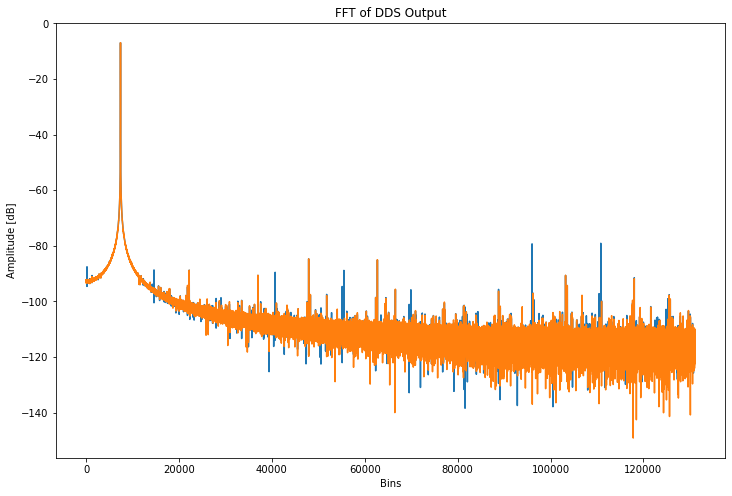

In [56]:
fig = plt.figure(figsize=(12,8))
fft_index = int(len(df_fft)/2) # Half of the FFT output

# First plot - undithered DDS output 
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])
fft_index = int(len(df_fft)/2) # Half of the FFT output 
plt.plot(df_fft[:fft_index])
plt.plot(df_dither_fft[:fft_index])
plt.title("FFT of DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')

# Using an Ugly Clock Rate

Clock sources like crystals and packaged oscillators generally come in nice integer values for ease of use. Values like 8MHz, 16MHz, and 25MHz are very common. However, these tend to be bad choices for DDS applications. Why? It's a radix issue. 

Every direct digital synthesizer depends on a numerically controlled oscillator to function. That's a big way of saying "an accumulator with a programmable offset". Since this is implemented digitally, the number is going to end up in hardware as a power of 2. With the exception of a few oddball values, clock crystals are generally sold off the shelf as integer values with base-10 tunings. (See earlier examples of 8MHz, 16MHz, and 25MHz.)

So, how do we get around this? Use a base-2 clock rate! 

The quickest way to demonstrate this is to modify our earlier example to run at $2^{27} [Hz]$, which, at ~134.2MHz, is the closest approximate to our original 100MHz clock rate.

In [60]:
clock_rate = 2**27
dds      = DirectDigitalSynthesis(clock_rate, 32, 4096, 12)
freq     = 2822400
tuning   = dds.freq_to_tuning(freq)
phase_base2    = dds.generate_phase_array(tuning, (2**20))
df_phase_base2 = dds.generate_dds_frame(dither_output=False)
df_fft_base2   = dds.generate_dds_spectrum()

Even as an undithered signal, we can see by inspection of the FFT that the trend of the noise dips rapidly below the window of the plot. Further inspection of the spur magnitudes shows that we yield a 3dB improvement in SFDR just by modifying the clock rate! 

In [61]:
spur_mags = [a for a in df_fft_base2[15000:fft_index] if (a > -90)]
print(spur_mags)
print("Bin Count: ", len(spur_mags))
print("Max Spur : ", max(spur_mags))

[-88.79047575325237, -82.43977363516987, -81.9477432177207, -82.32848796444854, -82.06125715926972, -88.32992172649978, -88.09121615170233, -88.31348421947271, -88.10818541298289]
Bin Count:  9
Max Spur :  -81.9477432177207


Adding dither improves this further, to a very respectable -88dB of SFDR.

In [63]:
df_phase_dither_base2 = dds.generate_dds_frame(dither_output=True)
df_fft_dither_base2   = dds.generate_dds_spectrum()
spur_mags = [a for a in df_fft_dither_base2[15000:fft_index] if (a > -90)]
print(spur_mags)
print("Bin Count: ", len(spur_mags))
print("Max Spur : ", max(spur_mags))

[-88.94434872091423, -88.40979465930018, -88.14644829470753, -88.49633311252711, -88.08650040185941]
Bin Count:  5
Max Spur :  -88.08650040185941


Where do all of these improvements come from? 

It's all in the radix. Recall that the frequency resolution of a DDS system is bounded, ultimately, by two parameters: the accumulator bit depth, and the input clock frequency. 

$$\Delta f = \frac{f_{clk}}{2^{B_{\theta{(n)}}}}$$

If we choose a base-10 clock, like 100MHz, our frequency resolution ends up being $100 [MHz] / 2^{32} = ~0.023 [Hz]$.

If we choose a base-2 clock, like $2^{27} = ~134.2 [MHz]$, we see a slight degradation in frequency resolution: $0.031 [Hz]$.

...but what we lose in 



# Modifying ROM Bit Depth

One good way to reduce noise in a DDS is to simply increase the bit depth of the sine lookup table. 



# Phase Dithering 



# Taylor Series Correction